In [60]:
import cv2
# from google.colab.patches import cv2_imshow
import numpy as np
from skimage import feature as ft
import joblib
from matplotlib import pyplot as plt

In [43]:
# from skimage import io
 
# img = io.imread("train/06/00006_00000_00000.png")
# io.imshow(img)

# Image Processing and Feature Extraction


## Preprocess image

In [61]:
def preprocess_img(imgBGR, erode_dilate = True):
    """ preprocess image.
    Args:
        img_BGR: a binary image.
        erode_dilate: enable erosion and dilation
    Return:
        img_bin: segmented image
    """
    rows, cols, _ = imgBGR.shape

    # increase saturation
    imgHSV = increase_saturation(imgBGR, 1.3)

    imgHSV = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2HSV)

    # Segment red and mask
    Rmin1 = np.array([0, 50, 50])
    Rmax1 = np.array([10, 255, 255])
    img_Rbin1 = inrange(imgHSV,Rmin1, Rmax1)

    Rmin2 = np.array([170, 50, 50])
    Rmax2 = np.array([180, 255, 255])
    img_Rbin2 = inrange(imgHSV,Rmin2, Rmax2)

    mask = img_Rbin1 + img_Rbin2

    img_bin = imgBGR.copy()
    img_bin[np.where(mask == 0)] = 0

    img_bin = cv2.cvtColor(img_bin, cv2.COLOR_BGR2GRAY)

    # post processing - opening
    if erode_dilate is True:
        kernel = np.array([[0,1,0],
                           [1,1,1],
                           [0,1,0]], np.uint8)
        img_bin = erosion(img_bin, kernel, 1)
        img_bin = dilation(img_bin, kernel, 1)

    return img_bin

In [62]:
def increase_saturation(image, inc):
  imghsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  (h, s, v) = cv2.split(imghsv)
  s = s * inc
  s = np.uint8(np.clip(s, 0, 255))
  imghsv = cv2.merge([h, s, v])
  output = cv2.cvtColor(imghsv, cv2.COLOR_HSV2BGR)
  return output

In [63]:
def hist_eq(image):
  bins_edges_min_max = [0, 255]
  num_bins = 256
  bin_count, bins_edges = np.histogram(image, num_bins, bins_edges_min_max)
  bins_start = bins_edges[:-1]
  pdf = bin_count / np.sum(bin_count)
  cdf = np.cumsum(pdf)
  freq = np.round(cdf*255).astype(int)
  output = freq[image]
  return output

In [64]:

def hist_equalization(image):
  b, g, r = cv2.split(image)
  img_list = [b, g, r]
  for img in range(len(img_list)):
    output = hist_eq(img_list[img])
    img_list[img] = output
  result = cv2.merge(img_list)
  return result

In [65]:
def inrange(image, min_value, max_value):
  h, w, _ = image.shape
  output = np.zeros((h,w), dtype=np.uint8)
  for channel in range(len(image)):
    h, w = image[channel].shape
    for i in range(h):
      # print(image[channel][i])
      if image[channel][i][0] >= min_value[0] and image[channel][i][0] <= max_value[0]:
        # print(image[channel][i])
        if image[channel][i][1] >= min_value[1] and image[channel][i][1] <= max_value[1]:
          if image[channel][i][2] >= min_value[2] and image[channel][i][2] <= max_value[2]:
            output[channel][i] = 255
            # print(image[channel][i])
        # else:
        #   output[channel][i] = 0
        # # print(output[channel][i])
  return output

## Detect Sign

In [49]:
def contour_detect(img_bin, min_area=0, max_area=-1):
    """detect contours in a binary image.
    Args:
        img_bin: a binary image.
        min_area: the minimum area of the contours detected.
            (default: 0)
        max_area: the maximum area of the contours detected.
            (default: -1, no maximum area limitation)
    Return:
        rects: a list of rects enclosing the contours. if no contour is detected, rects=[]
    """

    # initiate rectangles array to store ROI
    rects = []

    # find contours
    contours, _ = cv2.findContours(img_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(contours) == 0:
        return rects

    # filter contours based on area
    max_area = img_bin.shape[0]*img_bin.shape[1] if max_area<0 else max_area
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >= min_area and area <= max_area:
            x, y, w, h = cv2.boundingRect(contour)

            if(w < 10 or h < 10) : # noise
              continue

            rects.append([x,y,w,h])
    return rects

In [50]:
def draw_rects_on_img(img, rects):
    """ draw rects on an image.
    Args:
        img: an image where the rects are drawn on.
        rects: a list of rects.
    Return:
        img_rects: an image with rects.
    """
    img_copy = img.copy()
    for rect in rects:
        x, y, w, h = rect
        cv2.rectangle(img_copy, (x,y), (x+w,y+h), (0,255,0), 2)
    return img_copy

In [51]:
def crop_img(img, rect):
  """ crop image region on a rect boundary.
    Args:
        img: an image where the rects are drawn on.
        rect: array of coordinates -> [x, y, w, h].
    Return:
        proposal: cropped image / ROI.
    """
  rows, cols, _ = img.shape

  xc = int(rect[0] + rect[2]/2)
  yc = int(rect[1] + rect[3]/2)

  size = max(rect[2], rect[3])

  x1 = max(0, int(xc-size/2))
  y1 = max(0, int(yc-size/2))
  x2 = min(cols, int(xc+size/2))
  y2 = min(rows, int(yc+size/2))
  proposal = img[y1:y2, x1:x2]
  return proposal

## Feature Extraction

In [52]:
def feature_extract(cropped_image, resize=(64,64)):
    """extract feature from an image.
    Args:
        cropped_image: an image array.
        resize: size of the image for extracture.
    Return:
    features:  a ndarray vector.
    """

    # process cropped image
    processed_image, circles = preprocess_cropped(cropped_image, resize)

    # edge features
    edges = cv2.Canny(processed_image,100,200)

    feature = edges.flatten()

    return feature, circles, edges

In [53]:
def preprocess_cropped(cropped_image, resize=(64,64)):
    """ seperate object from background.
    Args:
        cropped_image: an image array.
        resize: size of the image for extracture.
    Return:
    features:  masked image and found circles.
    """
    cropped_image = cv2.resize(cropped_image, resize)
    rows, cols, _ = cropped_image.shape

    # bgr 2 hsv
    imgHSV = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)

    # mask red
    Rmin1 = np.array([0, 50, 50])
    Rmax1 = np.array([10, 255, 255])
    img_Rbin1 = inrange(imgHSV,Rmin1, Rmax1)

    Rmin2 = np.array([170, 50, 50])
    Rmax2 = np.array([180, 255, 255])
    img_Rbin2 = inrange(imgHSV,Rmin2, Rmax2)

    # combine mask
    red_mask = img_Rbin1 + img_Rbin2

    # apply mask
    img_bin = cropped_image.copy()
    img_bin[np.where(red_mask == 0)] = 0

    # Convert to b&w + threshold
    img_bin = cv2.cvtColor(img_bin, cv2.COLOR_BGR2GRAY)
    img_bin = cv2.blur(img_bin, (5,5))
    img_bin = threshold(img_bin, 5, 255)

    # fill region/contour
    contours, _ = cv2.findContours(img_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    mask = cv2.drawContours(img_bin, contours, -1, color=(255, 255, 255), thickness=cv2.FILLED)

    # mask background

    circles = cv2.HoughCircles(mask,cv2.HOUGH_GRADIENT,1,50, param1=50, param2=9,minRadius=20,maxRadius=0) # detect circles

    masked = cv2.bitwise_and(cropped_image,cropped_image, mask=mask)

    return masked, circles

In [54]:
def preprocess_cropped_steps(cropped_image, resize=(64,64)):
    """ seperate object from background.
    Args:
        cropped_image: an image array.
        resize: size of the image for extracture.
    Return:
    features:  masked image and found circles.
    """
    cropped_image = cv2.resize(cropped_image, resize)
    rows, cols, _ = cropped_image.shape

    # bgr 2 hsv
    imgHSV = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)

    # mask red
    Rmin1 = np.array([0, 50, 50])
    Rmax1 = np.array([10, 255, 255])
    img_Rbin1 = inrange(imgHSV,Rmin1, Rmax1)

    Rmin2 = np.array([170, 50, 50])
    Rmax2 = np.array([180, 255, 255])
    img_Rbin2 = inrange(imgHSV,Rmin2, Rmax2)

    # combine mask
    red_mask = img_Rbin1 + img_Rbin2

    # apply mask
    img_bin = cropped_image.copy()
    img_bin[np.where(red_mask == 0)] = 0

    print("\nmask:")
    plt.imshow(img_bin)
    plt.show()
    # cv2_imshow(img_bin)

    # Convert to b&w + threshold
    img_bin = cv2.cvtColor(img_bin, cv2.COLOR_BGR2GRAY)
    img_bin = cv2.blur(img_bin, (5,5))
    img_bin = threshold(img_bin, 5, 255)

    print("\nconvert to black and white:")
    plt.imshow(img_bin)
    plt.show()
    # cv2_imshow(img_bin)

    # fill region/contour
    contours, _ = cv2.findContours(img_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    mask = cv2.drawContours(img_bin, contours, -1, color=(255, 255, 255), thickness=cv2.FILLED)

    print("\nfill boundary:")
    plt.imshow(mask)
    plt.show()
    # cv2_imshow(mask)

    # mask background

    circles = cv2.HoughCircles(mask,cv2.HOUGH_GRADIENT,1,50, param1=50, param2=9,minRadius=20,maxRadius=0) # detect circles

    masked = cv2.bitwise_and(cropped_image,cropped_image, mask=mask)

    print("\nmasked image:")
    plt.imshow(masked)
    plt.show()
    # cv2_imshow(masked)

    return masked, circles

In [55]:
def threshold(image, thresh, max_value):
  rows, cols = image.shape
  output = np.zeros((rows, cols), dtype=np.uint8)
  for i in range(rows):
    for j in range(cols):
      if image[i][j] > thresh:
        output[i][j] = max_value
  return output

In [56]:
def erosion(image, kernel, padding=0):
  img_operated = image.copy() #this will be the image

  padding_value = 1
  padded = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, padding_value)

  vertical_window = padded.shape[0] - kernel.shape[0] #final vertical window position
  horizontal_window = padded.shape[1] - kernel.shape[1] #final horizontal window position
  vertical_pos = 0
  while vertical_pos <= vertical_window:
    horizontal_pos = 0
    while horizontal_pos <= horizontal_window:
      dilation_flag = False
      erosion_flag = False
      for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
          if kernel[i][j] == 1:
            #if we find 0, then break the second loop
            if padded[vertical_pos+i][horizontal_pos+j] == 0:
              erosion_flag = True
              break

          img_operated[vertical_pos, horizontal_pos] = 0
          break

      #increase the horizontal window position
      horizontal_pos += 1
      #increase the vertical window position
      vertical_pos += 1

  return img_operated

In [57]:
def dilation(image, kernel, padding=0):
  img_operated = image.copy()

  padding_value = 0
  padded = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, padding_value)

  vertical_window = padded.shape[0] - kernel.shape[0] #final vertical window position
  horizontal_window = padded.shape[1] - kernel.shape[1] #final horizontal window position
  vertical_pos = 0
  while vertical_pos <= vertical_window:
    horizontal_pos = 0
    while horizontal_pos <= horizontal_window:
      dilation_flag = False
      erosion_flag = False
      for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
          if kernel[i][j] == 1:
            #if we find 1, then break the second loop
            if padded[vertical_pos+i][horizontal_pos+j] == 1:
              dilation_flag = True
              break

          img_operated[vertical_pos, horizontal_pos] = 1
          break

      #increase the horizontal window position
      horizontal_pos += 1
      #increase the vertical window position
      vertical_pos += 1

## Classification with SVM

In [58]:
import os
from sklearn.svm import SVC

### Label

In [67]:
cls_names = ["larangan-mutar-arah", "larangan-belok-kiri","larangan-klakson","kecepatan-120","kuburan","jalur-truk"]
img_label = {"larangan-mutar-arah":2,"larangan-belok-kiri":5,"larangan-klakson":6,"kecepatan-120":8,"kuburan":11,"jalur-truk":16}

## Import Dataset

In [68]:
# hati_hati_longsor_train = os.listdir("train/01")
larangan_mutar_arah_train = os.listdir("train/02")
# jalan_licin_train= os.listdir("train/03")
# satu_jalur_train = os.listdir("train/04")
larangan_belok_kiri_train = os.listdir("train/05")
larangan_klakson = os.listdir("train/07")
kecepatan_120_train = os.listdir("train/08")
# kecepatan_120_train = os.listdir("train/29")
# hati_hati_train = os.listdir("train/18")
kuburan_train = os.listdir("train/11")
jalur_truk_train = os.listdir("train/16")
# background_train = os.listdir("train/50")
# background_train = os.listdir("drive/Shareddrives/Final_Project_PCD/dataset_kita/train/background")
print(jalur_truk_train)

# larangan_belok_kiri_test = os.listdir("drive/Shareddrives/Final_Project_PCD/dataset_kita/test/larangan-belok-kiri")
# larangan_belok_kanan_test = os.listdir("drive/Shareddrives/Final_Project_PCD/dataset_kita/test/larangan-belok-kanan")
# larangan_berhenti_test = os.listdir("drive/Shareddrives/Final_Project_PCD/dataset_kita/test/larangan-berhenti")
# background_test = os.listdir("drive/Shareddrives/Final_Project_PCD/dataset_kita/test/background")
# print(larangan_berhenti_test)

['00016_00000_00000.png', '00016_00000_00001.png', '00016_00000_00002.png', '00016_00000_00003.png', '00016_00000_00004.png', '00016_00000_00005.png', '00016_00000_00006.png', '00016_00000_00007.png', '00016_00000_00008.png', '00016_00000_00009.png', '00016_00000_00010.png', '00016_00000_00011.png', '00016_00000_00012.png', '00016_00000_00013.png', '00016_00000_00014.png', '00016_00000_00015.png', '00016_00000_00016.png', '00016_00000_00017.png', '00016_00000_00018.png', '00016_00000_00019.png', '00016_00000_00020.png', '00016_00000_00021.png', '00016_00000_00022.png', '00016_00000_00023.png', '00016_00000_00024.png', '00016_00000_00025.png', '00016_00000_00026.png', '00016_00000_00027.png', '00016_00000_00028.png', '00016_00000_00029.png', '00016_00001_00000.png', '00016_00001_00001.png', '00016_00001_00002.png', '00016_00001_00003.png', '00016_00001_00004.png', '00016_00001_00005.png', '00016_00001_00006.png', '00016_00001_00007.png', '00016_00001_00008.png', '00016_00001_00009.png',

In [69]:
dataset_train = []
dataset_train.extend(jalur_truk_train)
dataset_train.extend(kuburan_train)
# dataset_train.extend(hati_hati_longsor_train)
dataset_train.extend(kecepatan_120_train)
dataset_train.extend(larangan_mutar_arah_train)
dataset_train.extend(larangan_belok_kiri_train)
dataset_train.extend(larangan_klakson)
# dataset_train.extend(background_train)
# dataset_train.extend(background_train)
# print(len(jalur_truk_train), len(hati_hati_train), len(kecepatan_120_train),len(hati_hati_longsor_train),
#       len(kuburan_train),len(background_train))

# dataset_test = []
# dataset_test.extend(larangan_belok_kiri_test)
# dataset_test.extend(larangan_belok_kanan_test)
# dataset_test.extend(larangan_berhenti_test)
# dataset_test.extend(background_test)
# print(len(larangan_belok_kiri_test), len(larangan_belok_kanan_test), len(larangan_berhenti_test), len(background_test))

# dataset = {"train": dataset_train, "test": dataset_test}
dataset = {"train": dataset_train}
# print(dataset["test"])

In [ ]:
# from IPython.display import display, Image
# from matplotlib import pyplot as plt
# for image_name in dataset["train"]:

#     image_dir = image_name[3:5]
#     print(image_name[3:5])
#     image_dir = image_dir.replace(" ", "-")
#     image = cv2.imread("train" +"/"+ image_dir + "/"+ image_name )
#     plt.imshow(image)
#     plt.show()
#     # image = Image.open("train" +"/"+ image_dir + "/"+ image_name )
#     # display(Image(image))
#     # print(image)
#     # io.imshow(image)
#     print("train" +"/"+ image_dir + "/"+ image_name )

## Collect Features & Label from Dataset

In [70]:
def collect_features_and_labels(option):
  features = []
  labels = []

  # loop through dataset
  for image_name in dataset[option]:
    image_dir = image_name[3:5]
    print(image_name[3:5])
    image_dir = image_dir.replace(" ", "-")
    image = cv2.imread("train" +"/"+ image_dir + "/"+ image_name )
    plt.imshow(image)
    plt.show()
    # cv2_imshow(image)
    print(option +"/"+ image_dir+ "/"+ image_name )

    # extract feature from image
    local_feature = [0 for i in range(4096)] # empty feature
    max_radius = 0
    img_bin = preprocess_img(image, False)

    #
    possible_edge = np.zeros((64,64))

    for rect in contour_detect(img_bin):
      cropped_img = crop_img(image,rect)

      feature, circles, edges = feature_extract(cropped_img)
      try:
        if circles == None :
          # print("no circles")
          continue
      except:
        # features.append(feature)
          max_local_radius = 0
          for circle in circles:
            circ = circle[0]
            if max_local_radius < circ[2]: max_local_radius = circ[2]

          if max_radius < max_local_radius :
            possible_edge = edges
            local_feature = feature

    print("possible sign : ", image_name)
    # io.imshow(possible_edge)
    # cv2_imshow(possible_edge)
    plt.imshow(possible_edge)
    plt.show()
    features.append(local_feature)
    labels.append(image_dir)
  return np.array(features), np.array(labels)

In [ ]:
train_features, train_labels = collect_features_and_labels("train")

## SVM model training 

In [ ]:
clf = SVC(C=10, tol=1e-3, probability = True)
clf.fit(train_features, train_labels)

In [ ]:
# save model
joblib.dump(clf, "svm_model3.pkl")

## Test Model Accuracy

In [ ]:
# test_features, test_labels = collect_features_and_labels("test")

In [ ]:
# accuracy = clf.score(test_features, test_labels)
# accuracy

## Classify Signs in Image

In [71]:
def predict_image(image):
  print("Initial image:")
  # cv2.imshow("image",image)

  img_bin = preprocess_img(image, False)

  print("\nPreprocessed Image:")
  plt.imshow(img_bin)
  plt.show()
  # img = io.imread(img_bin)
  # # io.imshow(img)
  # cv2_imshow(img_bin)

  rects = contour_detect(img_bin)

  print("\nDetected ROI's: ")
  plt.imshow(draw_rects_on_img(image, rects))
  plt.show()
  # cv2_imshow(draw_rects_on_img(image, rects))
  for index, rect in enumerate(rects):
    cropped_img = crop_img(image,rect)
    # print(cropped_img.shape)
    print(f"\nPossible Red Sign {index+1}: ")
    # plt.imshow(cv2.resize(cropped_img, [64,64]))
    plt.imshow(cropped_img)
    plt.show()
    # cv2_imshow(cv2.resize(cropped_img, [64,64]))
    # pre_crop = preprocess_cropped(cropped_img)
    
    feature, circles, edges = feature_extract(cropped_img)
    plt.imshow(edges)
    plt.show()
    # cv2_imshow(edges)

    cls_prob, cls_name = predict_ROI(feature)
    print(f"Prediction: {cls_name} \nProb: {cls_prob}")

In [72]:
def predict_ROI(feature):
  # print("masuk sini")
  #import model
  model = joblib.load("svm_model3_1.pkl")

  feature = np.reshape(feature, (1,-1))

  cls_prob = model.predict_proba(feature)
  cls_prob = np.round(cls_prob, 2)[0]
  print(cls_prob)
  cls_num = np.argmax(cls_prob)
  cls_name = cls_names[cls_num]
  prop = cls_prob[cls_num]
  print(cls_name)
  return cls_prob, cls_name

## Test

In [73]:
# image = cv2.imread("Test/00018_00023_00026.png")
# image2 = cv2.imread("Test/00016_00000_00013.png")
# image3 = cv2.imread("Test/00008_00001_00023.png")
# image4 = cv2.imread("Test/23005.png")
# image5 = cv2.imread("Test/00011_00009_00023.png")
test = os.listdir("Test")
# image4 = cv2.imread("/content/drive/Shareddrives/Final_Project_PCD/dataset_kita/test/larangan-berhenti/larangan berhenti (89).jpg")
# image5 = cv2.imread("/content/drive/Shareddrives/Final_Project_PCD/dataset_kita/test/larangan-belok-kanan/larangan belok kanan (97).jpg")

In [75]:
print(test[10])

00016_00001_00028.png


Initial image:

Preprocessed Image:


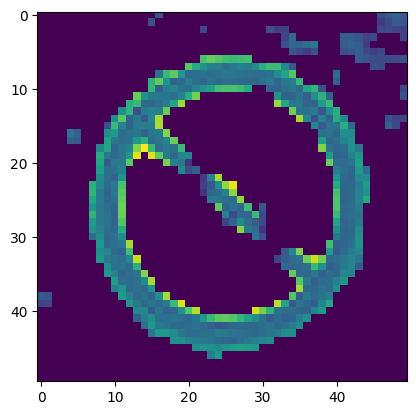


Detected ROI's: 


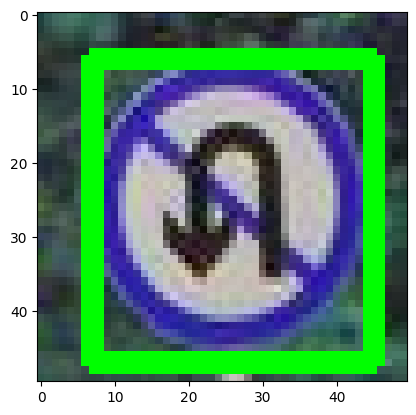


Possible Red Sign 1: 


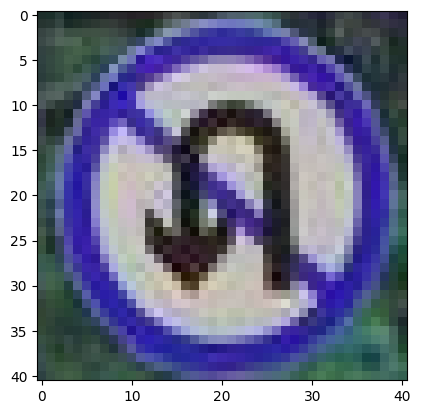

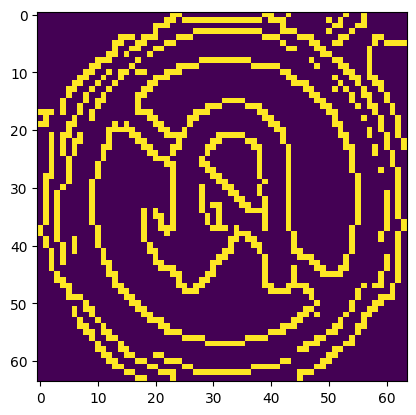

[0.01 0.95 0.01 0.01 0.   0.01 0.01 0.   0.01]
larangan-belok-kiri
Prediction: larangan-belok-kiri 
Prob: [0.01 0.95 0.01 0.01 0.   0.01 0.01 0.   0.01]


In [76]:
image = cv2.imread("Test/"+str(test[0]))
predict_image(image)

Initial image:

Preprocessed Image:


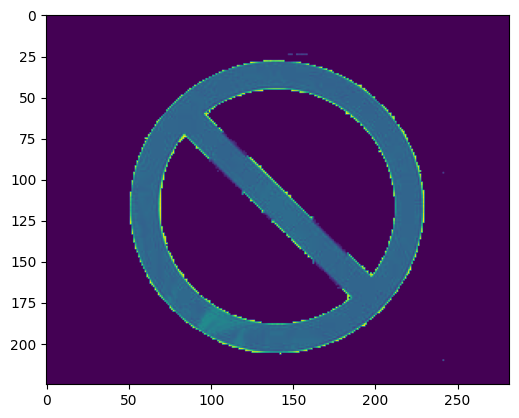


Detected ROI's: 


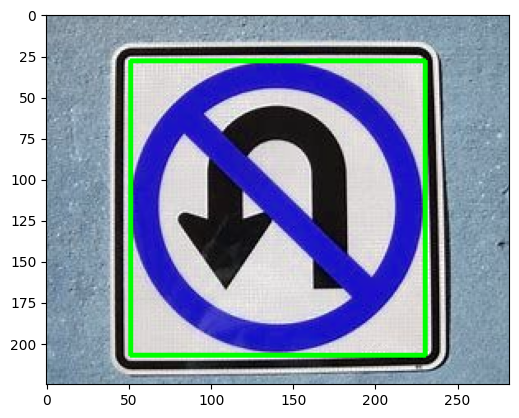


Possible Red Sign 1: 


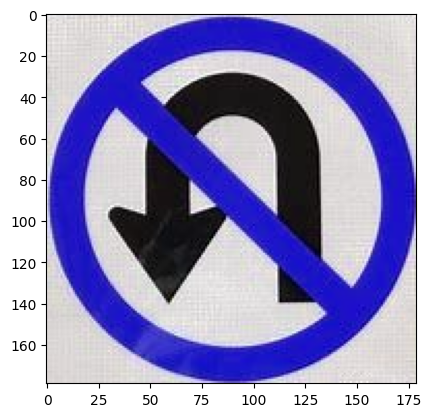

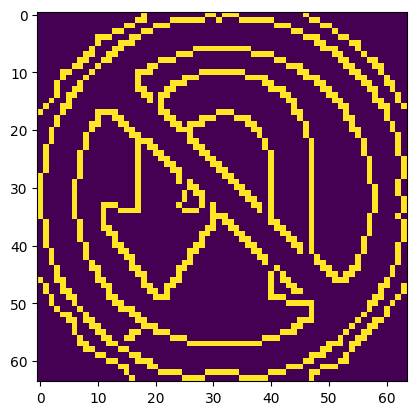

[0.01 0.95 0.01 0.01 0.   0.   0.01 0.01 0.01]
larangan-belok-kiri
Prediction: larangan-belok-kiri 
Prob: [0.01 0.95 0.01 0.01 0.   0.   0.01 0.01 0.01]


In [77]:
image2 = cv2.imread("Test/"+test[1])
predict_image(image2)

Initial image:

Preprocessed Image:


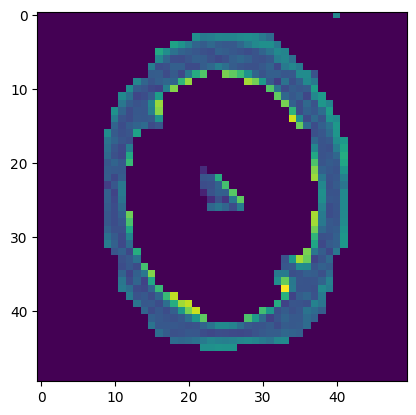


Detected ROI's: 


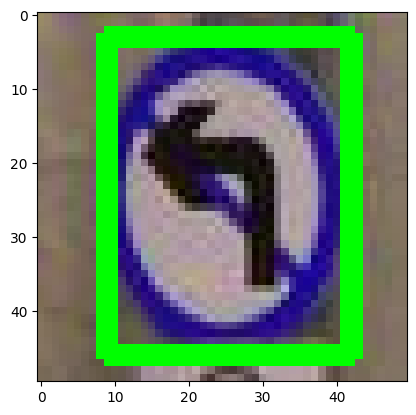


Possible Red Sign 1: 


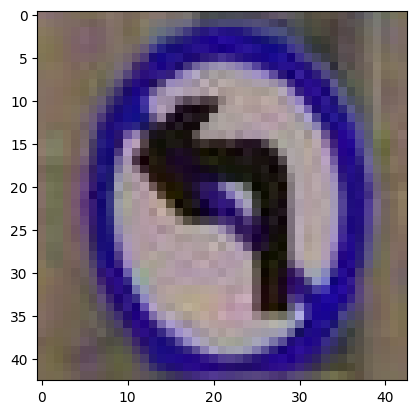

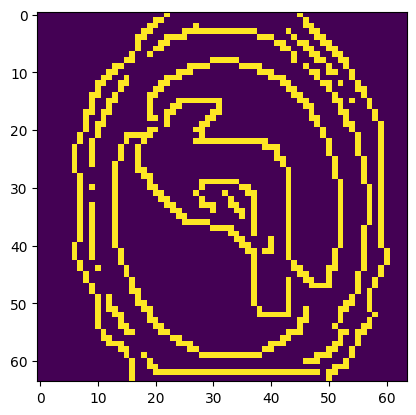

[0.03 0.02 0.01 0.01 0.77 0.05 0.05 0.03 0.04]
kuburan
Prediction: kuburan 
Prob: [0.03 0.02 0.01 0.01 0.77 0.05 0.05 0.03 0.04]


In [78]:
image3 = cv2.imread("Test/"+test[3])
predict_image(image3)

Initial image:

Preprocessed Image:


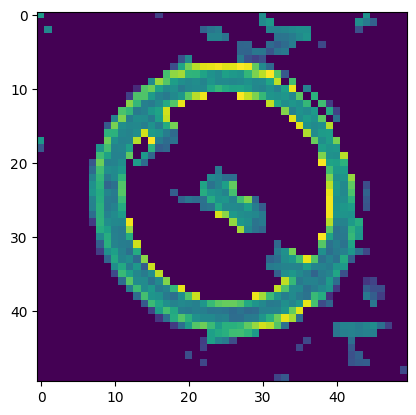


Detected ROI's: 


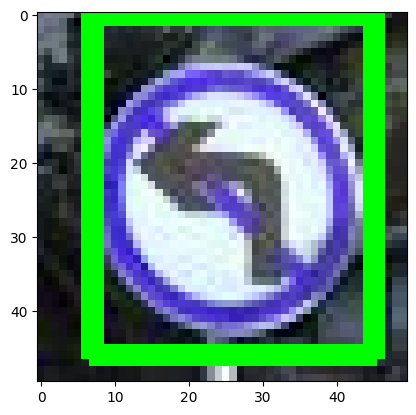


Possible Red Sign 1: 


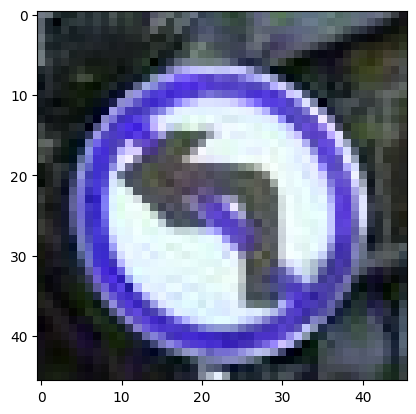

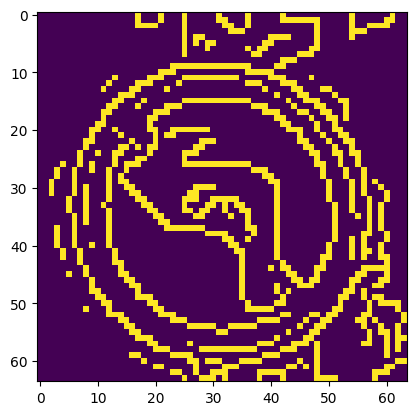

[0.03 0.01 0.01 0.01 0.78 0.04 0.04 0.04 0.04]
kuburan
Prediction: kuburan 
Prob: [0.03 0.01 0.01 0.01 0.78 0.04 0.04 0.04 0.04]


In [79]:
image4 = cv2.imread("Test/"+test[4])
predict_image(image4)

Initial image:

Preprocessed Image:


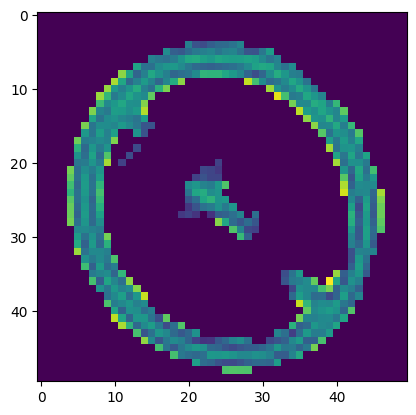


Detected ROI's: 


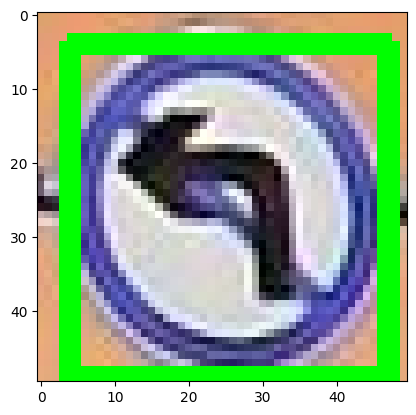


Possible Red Sign 1: 


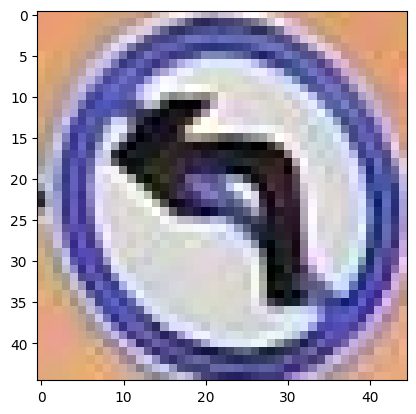

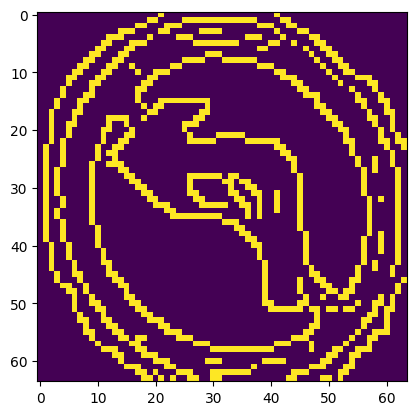

[0.03 0.02 0.01 0.01 0.76 0.06 0.05 0.03 0.05]
kuburan
Prediction: kuburan 
Prob: [0.03 0.02 0.01 0.01 0.76 0.06 0.05 0.03 0.05]


In [84]:
image5 = cv2.imread("Test/"+test[5])
predict_image(image5)

Initial image:

Preprocessed Image:


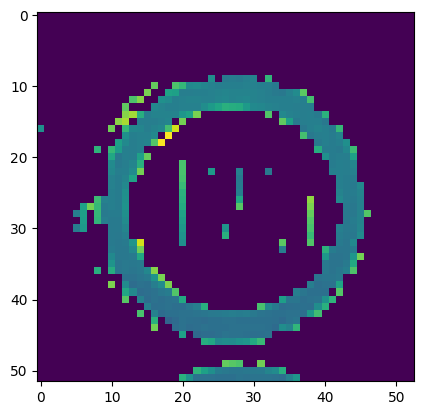


Detected ROI's: 


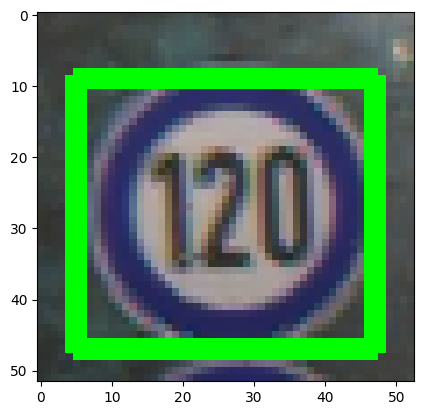


Possible Red Sign 1: 


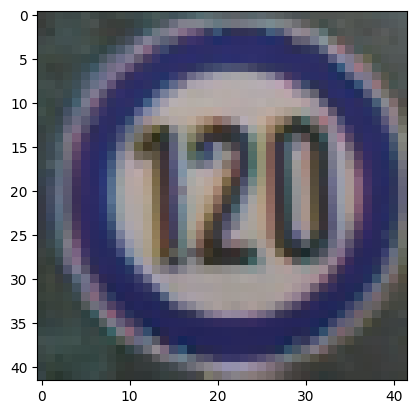

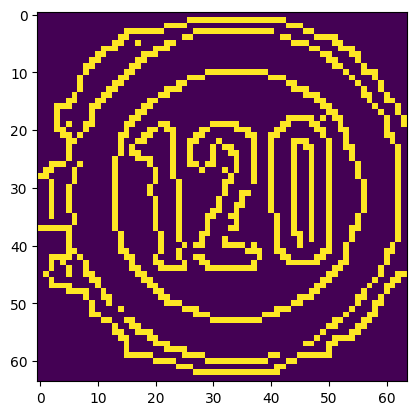

[0.01 0.01 0.01 0.01 0.02 0.03 0.64 0.11 0.14]


IndexError: list index out of range

In [83]:
image6 = cv2.imread("Test/"+test[6])
predict_image(image6)

Initial image:

Preprocessed Image:


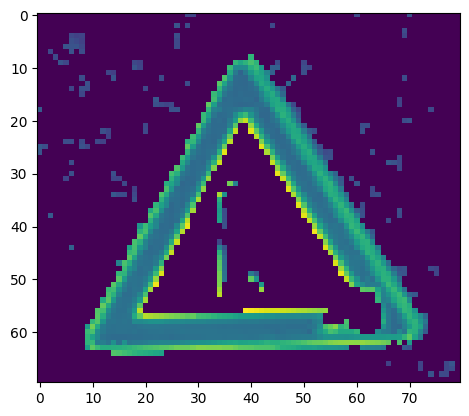


Detected ROI's: 


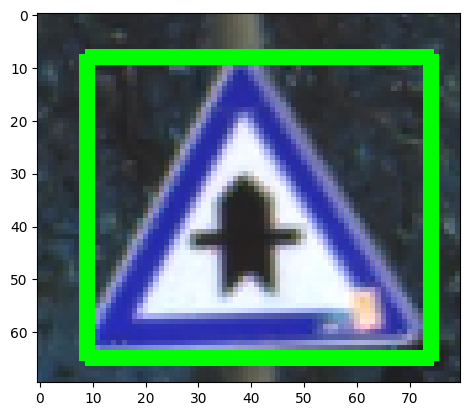


Possible Red Sign 1: 


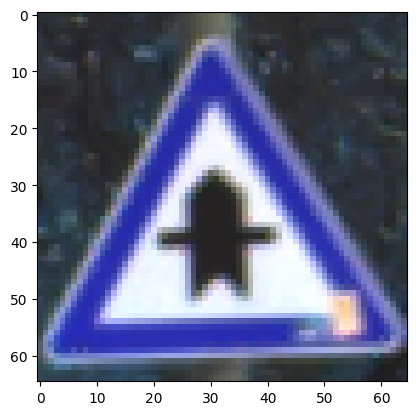

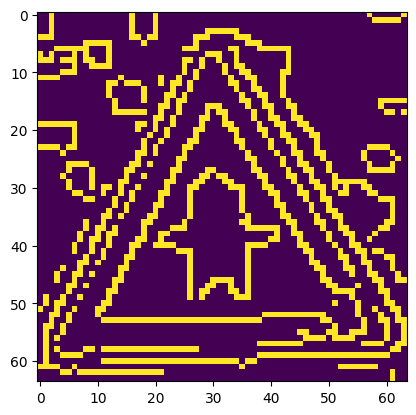

[0.01 0.01 0.01 0.01 0.01 0.02 0.24 0.58 0.11]


IndexError: list index out of range

In [82]:
image7 = cv2.imread("Test/"+test[8])
predict_image(image7)

Initial image:

Preprocessed Image:


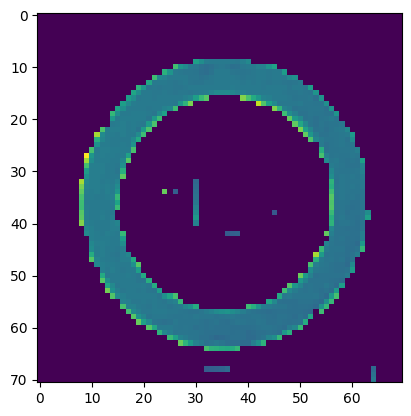


Detected ROI's: 


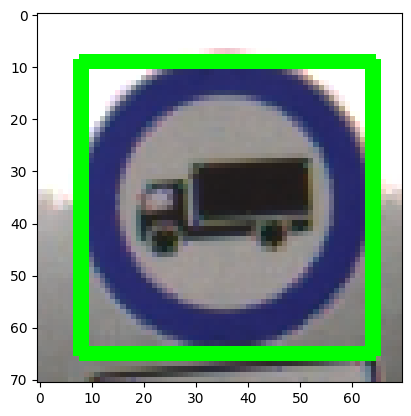


Possible Red Sign 1: 


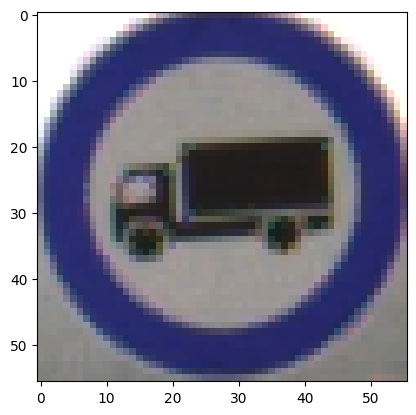

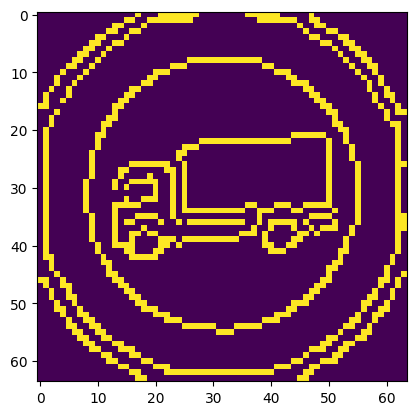

[0.03 0.08 0.03 0.03 0.03 0.06 0.13 0.06 0.55]


IndexError: list index out of range

In [81]:
image9 = cv2.imread("Test/"+test[9])
predict_image(image9)

Initial image:

Preprocessed Image:


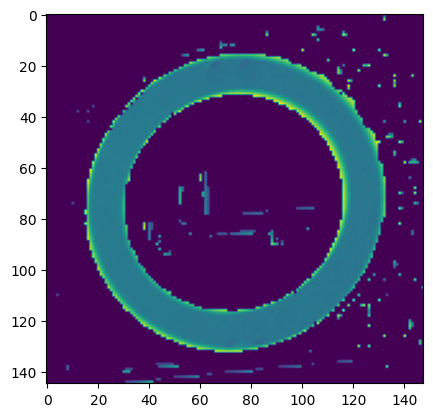


Detected ROI's: 


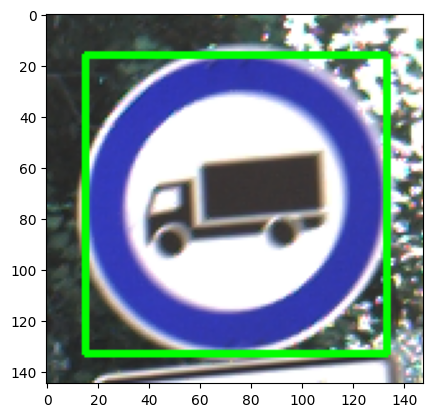


Possible Red Sign 1: 


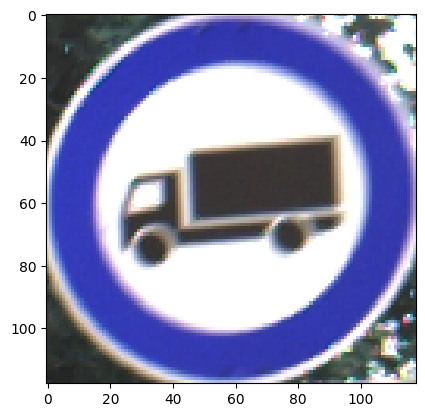

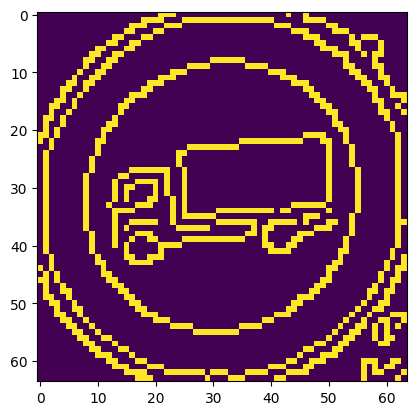

[0.02 0.03 0.02 0.02 0.02 0.04 0.12 0.06 0.66]


IndexError: list index out of range

In [80]:
image10 = cv2.imread("Test/"+test[10])
predict_image(image10)

In [ ]:
img_bin = preprocess_img(image, False)

print("Preprocessed Image:")
# cv2_imshow(img_bin)

rects = contour_detect(img_bin)

for index, rect in enumerate(rects):
    cropped_img = crop_img(image2,rect)
    print(cropped_img.shape)
    print(f"\nPossible Red Sign {index+1}: ")
    plt.imshow(cropped_img)
    plt.show()
    # cv2_imshow(cv2.resize(cropped_img, [64,64]))

    preprocess_cropped_steps(cropped_img)

    feature, circles, edges = feature_extract(cropped_img)
    plt.imshow(edges)
    plt.show()
    # cv2_imshow(edges)
